### Importing Required Libraries and Checking Versions

This cell imports all essential libraries used in the notebook:

In [1]:
# Core Python libraries
import os
from collections import Counter
import copy

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')  # Better inline plot rendering
import PIL

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR,CosineAnnealingLR
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision
from torchvision import datasets, models, transforms

# Model summary and info
import torchinfo
from torchinfo import summary

# Evaluation metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Progress bar for training loops
from tqdm import tqdm

In [2]:
# Print library versions for reproducibility
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

# Check Python version
!python --version

torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
torchinfo version :  1.8.0
numpy version :  1.26.4
matplotlib version :  3.7.2
Python 3.11.11


### ⚙️ Selecting the Best Available Device (CUDA / MPS / CPU)

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### 🎨 Custom Transform: Convert Grayscale Images to RGB

Defines a custom PyTorch transform to ensure all images are in **RGB format**.  
This is useful when working with pre-trained models (like DenseNet, ResNet), which expect 3-channel inputs.

- If an image is not already in RGB mode, it is converted using `PIL.Image.convert("RGB")`.


In [4]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

### 🧪 ImageNet Normalization Parameters

Defines the **mean and standard deviation values** used to normalize images based on the ImageNet dataset:

- These are standard values for models pre-trained on ImageNet.
- Normalization helps the model converge faster and perform better.


In [5]:
# ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

### 🧰 Data Augmentation and Preprocessing Pipelines

Defines the image transformation pipelines using `torchvision.transforms`:

- **`train_transforms`**: Includes data augmentation techniques to improve generalization:
  - Resize to 224×224
  - Random horizontal flip
  - Random rotation (±10°)
  - Random affine transformation (10% translation)
  - Color jitter (brightness and contrast)
  - Conversion to tensor
  - Normalization using ImageNet stats

- **`test_transforms`**: Only includes resizing, tensor conversion, and normalization  
  (No augmentation — keeps validation/test data consistent and realistic)

In [6]:
train_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

### 📂 Loading the Pneumonia Chest X-Ray Dataset

Loads the dataset from the directory structure using `ImageFolder`:

- Applies the appropriate transformations to each split:
  - **Training data** uses `train_transforms` (with augmentation)
  - **Validation and test data** use `test_transforms` (no augmentation)


In [25]:
classes = ['Normal','Pneumonia']

In [7]:
train_data = datasets.ImageFolder('/kaggle/input/pneumonia-xray-images/train', transform=train_transforms)
val_data = datasets.ImageFolder('/kaggle/input/pneumonia-xray-images/val', transform=test_transforms)
test_data = datasets.ImageFolder('/kaggle/input/pneumonia-xray-images/test', transform=test_transforms)

print("Length of training dataset:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data),'\n')

Length of training dataset: 4192
Validation set size: 1040
Test set size: 624 



### 📊 Visualizing Class Distribution in Training Dataset

Defines a function to count the number of samples per class in a given dataset using `Counter`.  
- Handles different dataset structures (`ImageFolder` or wrapped datasets).  
- Returns a pandas Series with class names and their respective counts.

In [8]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

100%|██████████| 4192/4192 [01:13<00:00, 57.13it/s]


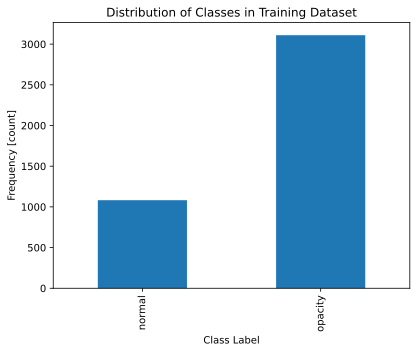

In [9]:
train_counts = class_counts(train_data)

# Bar chart from the function output
train_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

100%|██████████| 1040/1040 [00:17<00:00, 58.72it/s]


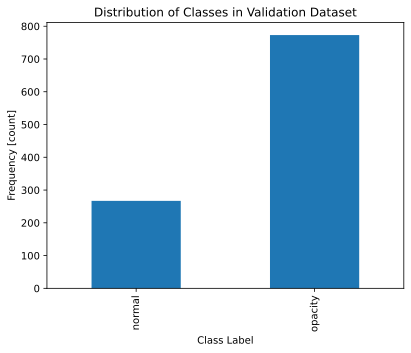

In [10]:
val_counts = class_counts(val_data)

# Bar chart from the function output
val_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

100%|██████████| 624/624 [00:09<00:00, 62.97it/s] 


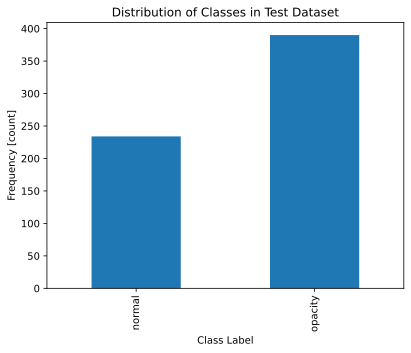

In [11]:
test_counts = class_counts(test_data)

# Bar chart from the function output
test_counts.plot(kind='bar')
# Axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Test Dataset");

### ⚖️ Handling Class Imbalance with Weighted Sampling

- Calculates **class weights inversely proportional to class frequencies** in the training dataset.  
- These weights ensure the minority class gets sampled more frequently to balance training.  
- Creates a `WeightedRandomSampler` using these weights to be passed to the `DataLoader` for balanced mini-batches during training.


In [12]:
# Calculate class weights
def get_class_weights(dataset):
    class_counts = [0, 0]  # [normal, pneumonia]
    for _, label in dataset:
        class_counts[label] += 1
    
    total = sum(class_counts)
    weights = [total / (len(class_counts) * count) for count in class_counts]
    return weights

# Create weighted sampler for training
class_weights = get_class_weights(train_data)
sample_weights = [class_weights[label] for _, label in train_data]

weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_data),
    replacement=True
)

### 🚚 Creating DataLoaders for Efficient Data Feeding

- Defines a batch size of 32.
- **Training DataLoader** uses the weighted sampler for balanced batches and enables multi-threaded loading (`num_workers=4`).
- **Validation DataLoader** loads batches without shuffling.
- **Test DataLoader** loads the entire test set in one batch for evaluation.
- `pin_memory=True` optimizes data transfer to GPU.
- `drop_last=True` in training and validation ensures consistent batch sizes during training.


In [13]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler,num_workers=4,pin_memory=True,drop_last=True)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,num_workers=2,pin_memory=True,drop_last=True)

test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False,num_workers=4,pin_memory=True)

### 🏗️ Loading Pretrained DenseNet-121 Model and Displaying Summary

- Loads DenseNet-121 architecture with default pretrained ImageNet weights.
- Uses `torchinfo.summary` to print a detailed overview of the model layers, parameters, and output shapes.
- The input size is set to match our image batch shape: `(batch_size, 3, 224, 224)`.


In [14]:
weights = models.DenseNet121_Weights.DEFAULT
model = models.densenet121(weights=weights)

height = 224
width = 224
summary(model,input_size=(batch_size,3,height,width))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [32, 1000]                --
├─Sequential: 1-1                        [32, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        128
│    └─ReLU: 2-3                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [32, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [32, 32, 56, 56]          45,440
│    │    └─_DenseLayer: 3-2             [32, 32, 56, 56]          49,600
│    │    └─_DenseLayer: 3-3             [32, 32, 56, 56]          53,760
│    │    └─_DenseLayer: 3-4             [32, 32, 56, 56]          57,920
│    │    └─_DenseLayer: 3-5             [32, 32, 56, 56]          62,080
│    │    └─_DenseLayer: 3-6             [32, 32, 56, 56]    

### 🔧 Fine-Tuning DenseNet-121 for Binary Classification

- Freezes most pretrained model parameters to prevent updating during training (transfer learning).  
- Replaces the final classifier with a new custom head:
  - Dropout for regularization
  - Fully connected layer reducing features to 256
  - ReLU activation
  - Additional Dropout
  - Final output layer with 2 units (for binary classes: normal vs pneumonia)  

In [15]:
# Unfreeze last DenseNet block and classifier for fine-tuning
for name, param in model.named_parameters():
    if 'features.denseblock4' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
print(f"Classification Layer Of Densenet-121: {model.classifier}")

Classification Layer Of Densenet-121: Linear(in_features=1024, out_features=1000, bias=True)


In [16]:
in_feats = model.classifier.in_features
new_class_layer = nn.Sequential(
    nn.Dropout(0.5),                 
    nn.Linear(in_feats, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
model.classifier = new_class_layer

print(f"New Classification Layer Of Densenet-121:\n {model.classifier}")

New Classification Layer Of Densenet-121:
 Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1024, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=2, bias=True)
)


### ⚙️ Defining Loss Function, Optimizer, and Learning Rate Scheduler

- **Loss function**: Cross-entropy loss for multi-class (binary) classification.  
- **Optimizer**: AdamW optimizer with weight decay (L2 regularization) to prevent overfitting.  
- **Scheduler**: CosineAnnealingLR gradually adjusts the learning rate following a cosine curve over T_max epochs, allowing the learning rate to periodically decrease and then reset, which can help the model escape local minima and improve convergence.


In [17]:
lossfun = nn.CrossEntropyLoss()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

### 🚀 Training Loop with Validation, Early Stopping, and Model Checkpointing

This function trains the model and includes:

- Moves model to the specified device (CPU/GPU).
- For each epoch:
  - Trains the model on the training dataset and tracks batch-wise loss and accuracy.
  - Evaluates performance on the validation set without gradient updates.
  - Prints training and validation losses and accuracies.
- Applies a learning rate scheduler if provided:
  - Supports `ReduceLROnPlateau` and other schedulers like `StepLR`.
- Implements early stopping:
  - Stops training if validation accuracy does not improve for a set patience.
  - Saves the best model weights to disk.
- Returns the trained model along with lists of training and validation accuracy and loss per epoch.


In [18]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    lossfun,
    epochs=10,
    device='cpu',
    save_path='/kaggle/working/best_model.pth',
    patience=3,
    scheduler=None,
):
    model.to(device)
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) 
    early_stop_counter = 0 
    
    # Initialize lists
    trainAcc = []
    trainLoss = [0.0] * epochs 
    valAcc = []
    valLoss = [0.0] * epochs  
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Training phase
        train_batchAcc = []
        train_batchLoss = []
        model.train()
        
        for X, y in tqdm(train_loader, desc='Training', leave=True):
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = lossfun(yHat, y)  
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            train_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
            train_batchLoss.append(loss.item())
        
        # Store epoch metrics
        trainAcc.append(np.mean(train_batchAcc))
        trainLoss[epoch - 1] = np.mean(train_batchLoss) 
        
        print(f"Training Loss: {trainLoss[epoch - 1]:.4f} | Training Accuracy: {trainAcc[-1]:.2f}%")
        
        # Validation phase
        model.eval()
        val_batchAcc = []
        val_batchLoss = []
        
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc='Validating', leave=True):
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = lossfun(yHat, y)
                
                val_batchAcc.append(100 * torch.mean((torch.argmax(yHat, dim=1) == y).float()).item())
                val_batchLoss.append(loss.item())
        
        # Store epoch metrics
        valAcc.append(np.mean(val_batchAcc))
        valLoss[epoch - 1] = np.mean(val_batchLoss) 
        
        print(f"Validation Loss: {valLoss[epoch - 1]:.4f} | Validation Accuracy: {valAcc[-1]:.2f}%")
        
        # Learning rate scheduling
        if scheduler:
            if hasattr(scheduler, 'step'):
                # For ReduceLROnPlateau
                if 'ReduceLROnPlateau' in str(type(scheduler)):
                    scheduler.step(valLoss[epoch - 1]) 
                else:
                    # For other schedulers like StepLR
                    scheduler.step()
        
        # Early stopping and model saving
        if valAcc[-1] > best_val_acc:
            best_val_acc = valAcc[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print(f"✅ New best validation accuracy: {best_val_acc:.2f}%")
        else:
            early_stop_counter += 1
            print(f"⏳ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        
        if early_stop_counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\n🏆 Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    
    return model, trainAcc, trainLoss, valAcc, valLoss

### 🎯 Start Model Training

  - 20 epochs,
  - early stopping patience set to 5

In [19]:
# Train
model,trainAcc, trainLoss, valAcc, valLoss = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    lossfun,
    epochs=20,
    device=device,
    scheduler=scheduler,
    patience=5,
    save_path='/kaggle/working/best_model.pth'
)


Epoch 1/20


Training: 100%|██████████| 131/131 [00:42<00:00,  3.05it/s]


Training Loss: 0.2803 | Training Accuracy: 88.98%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Validation Loss: 0.1182 | Validation Accuracy: 96.09%
✅ New best validation accuracy: 96.09%

Epoch 2/20


Training: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]


Training Loss: 0.1060 | Training Accuracy: 96.14%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Validation Loss: 0.1028 | Validation Accuracy: 96.97%
✅ New best validation accuracy: 96.97%

Epoch 3/20


Training: 100%|██████████| 131/131 [00:44<00:00,  2.94it/s]


Training Loss: 0.0783 | Training Accuracy: 97.21%


Validating: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Validation Loss: 0.0665 | Validation Accuracy: 97.75%
✅ New best validation accuracy: 97.75%

Epoch 4/20


Training: 100%|██████████| 131/131 [00:43<00:00,  3.01it/s]


Training Loss: 0.0713 | Training Accuracy: 97.50%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


Validation Loss: 0.0653 | Validation Accuracy: 97.56%
⏳ No improvement. Early stop counter: 1/5

Epoch 5/20


Training: 100%|██████████| 131/131 [00:45<00:00,  2.91it/s]


Training Loss: 0.0594 | Training Accuracy: 97.95%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.09it/s]


Validation Loss: 0.0560 | Validation Accuracy: 98.34%
✅ New best validation accuracy: 98.34%

Epoch 6/20


Training: 100%|██████████| 131/131 [00:43<00:00,  3.00it/s]


Training Loss: 0.0385 | Training Accuracy: 98.54%


Validating: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Validation Loss: 0.0572 | Validation Accuracy: 97.85%
⏳ No improvement. Early stop counter: 1/5

Epoch 7/20


Training: 100%|██████████| 131/131 [00:43<00:00,  2.98it/s]


Training Loss: 0.0384 | Training Accuracy: 98.76%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Validation Loss: 0.0566 | Validation Accuracy: 97.66%
⏳ No improvement. Early stop counter: 2/5

Epoch 8/20


Training: 100%|██████████| 131/131 [00:44<00:00,  2.96it/s]


Training Loss: 0.0460 | Training Accuracy: 98.54%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Validation Loss: 0.0550 | Validation Accuracy: 97.95%
⏳ No improvement. Early stop counter: 3/5

Epoch 9/20


Training: 100%|██████████| 131/131 [00:43<00:00,  3.02it/s]


Training Loss: 0.0322 | Training Accuracy: 98.90%


Validating: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Validation Loss: 0.0536 | Validation Accuracy: 98.05%
⏳ No improvement. Early stop counter: 4/5

Epoch 10/20


Training: 100%|██████████| 131/131 [00:43<00:00,  3.03it/s]


Training Loss: 0.0341 | Training Accuracy: 98.95%


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]

Validation Loss: 0.0544 | Validation Accuracy: 97.95%
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered.

🏆 Training completed. Best validation accuracy: 98.34%


### 📊 Plotting Training and Validation Metrics

- Visualizes the loss curves for both training and validation sets over epochs.  
- Visualizes the accuracy curves for both training and validation sets over epochs.  
- Helps in diagnosing model performance, underfitting, or overfitting visually.


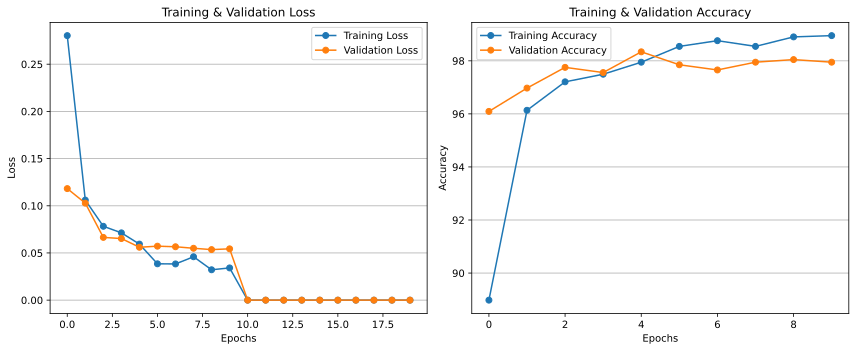

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax[0].plot(trainLoss, 'o-', label="Training Loss")
ax[0].plot(valLoss, 'o-', label="Validation Loss")
ax[0].set_title("Training & Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(axis='y')

# Plot training and validation accuracy
ax[1].plot(trainAcc, 'o-', label="Training Accuracy")
ax[1].plot(valAcc, 'o-', label="Validation Accuracy")
ax[1].set_title("Training & Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(axis='y') 

plt.tight_layout()
plt.show()

### 🔮 Prediction Function

- Sets the model to evaluation mode to disable dropout and batch norm updates.  
- Iterates through the provided data loader without tracking gradients (inference mode).  
- Computes softmax probabilities for each input batch and accumulates them.  
- Returns a tensor containing the predicted class probabilities for the entire dataset.

In [21]:
def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=True):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs


### 🧪 Generate Predictions on Test Set

- Uses the trained model to predict class probabilities on the test dataset.  
- Converts probabilities to predicted class labels by selecting the class with highest probability.  
- Prints the predicted labels tensor.

In [22]:
test_probabilities = predict(model,test_loader,device)
test_predictions = torch.argmax(test_probabilities,dim=1)

print(test_predictions)

Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.96s/it]


tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### 📉 Confusion Matrix for Test Set Predictions

- Collects true labels from the test dataset.  
- Computes the confusion matrix comparing true labels with model predictions.  
- Visualizes the confusion matrix with labeled axes and a blue color map.  
- Saves the confusion matrix plot to disk for later reference.


Get Labels: 100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


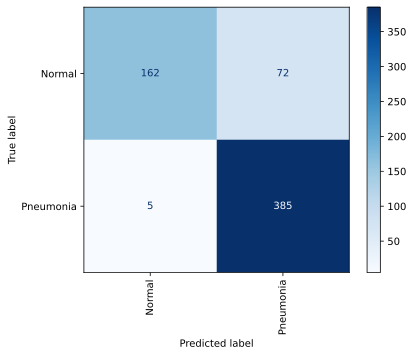

In [26]:
targets_test = torch.cat([labels for _, labels in tqdm(test_loader, desc="Get Labels")])

cm = confusion_matrix(targets_test.cpu(), test_predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.savefig('/kaggle/working/ConfusionMatrix');

In [24]:
class_report = classification_report(targets_test.cpu(), test_predictions.cpu())

print(f"Classification Report:\n {class_report}")

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.69      0.81       234
           1       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624

